In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from autoencoder import autoencoder
from tensorflow.keras.datasets import mnist
from clusteringlayer import ClusteringLayer
from tensorflow.keras.initializers import VarianceScaling

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)

In [3]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale = 1. / 3., mode = 'fan_in',
                           distribution = 'uniform')
pretrain_optimizer = tf.keras.optimizers.SGD(lr = 1, momentum = 0.9)
pretrain_epochs = 20
batch_size = 256

In [4]:
autoencoder, encoder = autoencoder(dims, init = init)

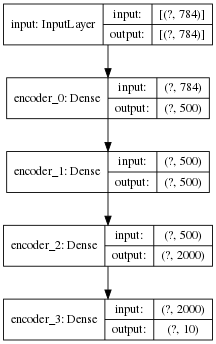

In [5]:
tf.keras.utils.plot_model(encoder, show_shapes = True, dpi = 64)

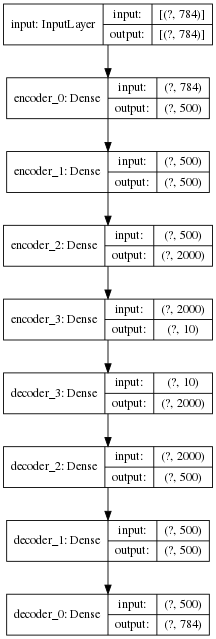

In [6]:
tf.keras.utils.plot_model(autoencoder, show_shapes = True, dpi = 64)

In [7]:
autoencoder.compile(optimizer = pretrain_optimizer, loss = 'mse')
autoencoder.fit(x, x, batch_size = batch_size, epochs = pretrain_epochs)

Epoch 1/20
274/274 [==============================] - 2s 5ms/step - loss: 0.0649
Epoch 2/20
274/274 [==============================] - 2s 6ms/step - loss: 0.0441
Epoch 3/20
274/274 [==============================] - 2s 6ms/step - loss: 0.0318
Epoch 4/20
274/274 [==============================] - 2s 6ms/step - loss: 0.0271
Epoch 5/20
274/274 [==============================] - 2s 6ms/step - loss: 0.0241
Epoch 6/20
274/274 [==============================] - 2s 6ms/step - loss: 0.0225
Epoch 7/20
274/274 [==============================] - 1s 5ms/step - loss: 0.0213
Epoch 8/20
274/274 [==============================] - 2s 6ms/step - loss: 0.0204
Epoch 9/20
274/274 [==============================] - 2s 6ms/step - loss: 0.0196
Epoch 10/20
274/274 [==============================] - 2s 5ms/step - loss: 0.0190
Epoch 11/20
274/274 [==============================] - 1s 5ms/step - loss: 0.0185
Epoch 12/20
274/274 [==============================] - 1s 5ms/step - loss: 0.0180
Epoch 13/20
274/274 [====

In [8]:
clustering_layer = ClusteringLayer(10, name = 'clustering')(encoder.output)
model = tf.keras.models.Model(inputs = encoder.input, outputs = clustering_layer)

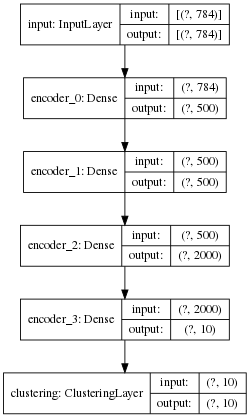

In [9]:
tf.keras.utils.plot_model(model, show_shapes = True, dpi = 64)

In [10]:
model.compile(optimizer = tf.keras.optimizers.SGD(0.01, 0.9), loss = 'kld')

In [12]:
#  initialize cluster centers using k-means
kmeans = KMeans(n_clusters = 10, n_init = 20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [13]:
y_pred_last = np.copy(y_pred)

In [14]:
model.get_layer(name = 'clustering').set_weights([kmeans.cluster_centers_])

In [15]:
# Compute p_i by first raising q_i to the second power and then normalizing by frequency per cluster:

# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [16]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

In [17]:
tol = 0.001

In [18]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose = 0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.accuracy_score(y, y_pred), 5)
            nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
            ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x = x[idx], y = p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

Iter 0: acc = 0.24824, nmi = 0.66521, ari = 0.59836  ; loss= 0
Iter 140: acc = 0.25389, nmi = 0.67378, ari = 0.61024  ; loss= 0.04657
Iter 280: acc = 0.25897, nmi = 0.68498, ari = 0.62197  ; loss= 0.13647
Iter 420: acc = 0.26187, nmi = 0.69749, ari = 0.63411  ; loss= 0.19469
Iter 560: acc = 0.26506, nmi = 0.70943, ari = 0.64784  ; loss= 0.22149
Iter 700: acc = 0.26516, nmi = 0.71745, ari = 0.65487  ; loss= 0.22737
Iter 840: acc = 0.26566, nmi = 0.72493, ari = 0.66179  ; loss= 0.22258
Iter 980: acc = 0.26659, nmi = 0.72903, ari = 0.66575  ; loss= 0.22001
Iter 1120: acc = 0.26786, nmi = 0.73325, ari = 0.67112  ; loss= 0.21502
Iter 1260: acc = 0.26867, nmi = 0.73561, ari = 0.67309  ; loss= 0.21056
Iter 1400: acc = 0.26900, nmi = 0.73897, ari = 0.67726  ; loss= 0.19901
Iter 1540: acc = 0.26924, nmi = 0.74011, ari = 0.67828  ; loss= 0.20166
Iter 1680: acc = 0.26994, nmi = 0.74230, ari = 0.68091  ; loss= 0.18971
Iter 1820: acc = 0.26997, nmi = 0.74311, ari = 0.68052  ; loss= 0.19086
Iter 196

In [19]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.accuracy_score(y, y_pred), 5)
    nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
    ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.26870, nmi = 0.74458, ari = 0.68189  ; loss= 0.10445
